In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns

import numpy as np
import pandas as pd

from tqdm import tqdm
import torch

from torch.utils.data import DataLoader


import sys
sys.path.append('../src')
sys.path.append('../experiments_angle/')

### Notes from initial runs


Starting simple, moving more complex:
#### Single image
1. Concentrated distributions are much easier to learn: they start from a lower baseline.
2. All distributions converge within 100 epochs

#### Many images
- Eval loss starts around the same place as the correspondingly concentrated single image: good initial indication.
- Seems to learn successfully initially.
- Train and validation losses both appear to plateau around 0.15. Probably a sign that we should unfreeze there.
- output norm stay well behaved. It is small, but not overly so.

#### Many images - flat distribution
- fast learning initially.
- achieves about 0.15 train and validation losses

#### Training the ResNet:
- learning rate 1E-5 is too large: learned performance vanishes within the first 20 steps, norm blows up
- learning rate 1E-6 is reasonable: performance increases.
- Achieves very good validation performance ~0.002

## Trying out the SVM for discrimination performance

In [2]:
from models.face_angle import EstimateAngle
from data.rotated_faces import ConsistentRotationDataset, RotatedFacesDataset
from pytorch_lightning import Trainer

model_ckpt = '../experiments_angle/2025-10-17(00:20:29)-fullnetwork/checkpoints/best.ckpt'

model = EstimateAngle.load_from_checkpoint(model_ckpt)


W1017 11:36:02.410000 10941 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


import error: No module named 'triton'


#### Double check the numbers from wandb curves

In [3]:
ds = RotatedFacesDataset(loc=0, kappa=0.1, split='valid')
dl = DataLoader(ds, batch_size=32)
trainer = Trainer()
trainer.test(model, dl)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/luke/.local/defaultPythonEnv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/loss         │   0.0021671114955097437   │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.0021671114955097437}]

Looks good.

## Compare output embeddings

In [4]:
ds1 = ConsistentRotationDataset(0.)
ds2 = ConsistentRotationDataset(0.1)

In [128]:
dl1 = torch.utils.data.DataLoader(ds1, batch_size=256, shuffle=False)
dl2 = torch.utils.data.DataLoader(ds2, batch_size=256, shuffle=False)

In [129]:
imgs1, _ = next(iter(dl1))
imgs2, _ = next(iter(dl2))

In [130]:
embeddings_1 = model.forward(imgs1).detach().cpu()
embeddings_2 = model.forward(imgs2).detach().cpu()

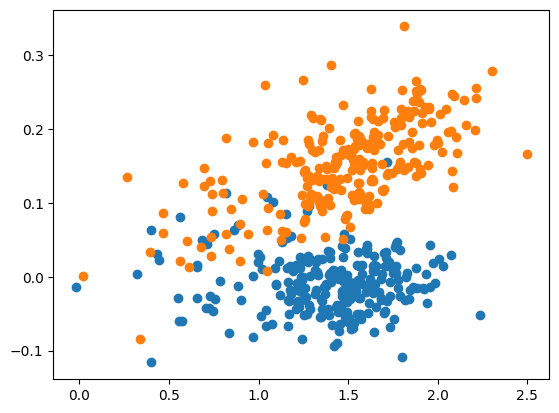

In [131]:
plt.scatter(embeddings_1[:,0], embeddings_1[:,1])
plt.scatter(embeddings_2[:,0], embeddings_2[:,1])

Ok. Even with very good loss, there seem to be failures of linear discriminability, so our LD measurements are probably meaningful.

#### Explore SVM outputs:

In [137]:
from sklearn.svm import SVC
# need to adjust C to get a better classification...
svm = SVC(kernel='linear', C=1.)
svm2 = SVC(kernel='linear', C=1000.)

In [133]:
all_embeddings = torch.concat([embeddings_1, embeddings_2])
labels = torch.concat([torch.zeros(len(embeddings_1)), torch.ones(len(embeddings_2))])

In [138]:
svm.fit(all_embeddings, labels)
svm2.fit(all_embeddings, labels)

SVC(C=1000.0, kernel='linear')

(-0.2, 0.4)

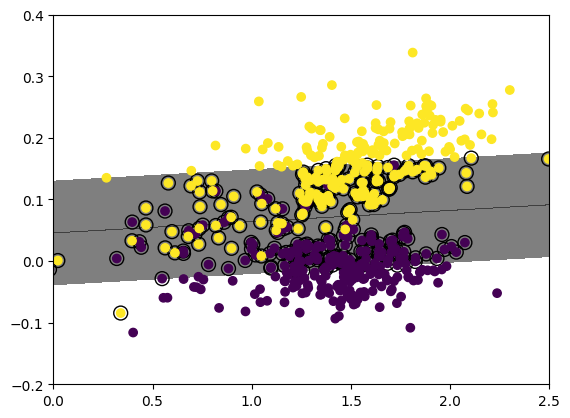

In [135]:
from sklearn.inspection import DecisionBoundaryDisplay
DecisionBoundaryDisplay.from_estimator(
    svm,
    all_embeddings,
    plot_method="contourf",
    colors='k',
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
    alpha=0.5
)

# plot support vectors
plt.scatter(
    svm.support_vectors_[:, 0],
    svm.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.scatter(all_embeddings[:,0], all_embeddings[:,1], c=labels)
plt.xlim([0, 2.5])
plt.ylim([-0.2, 0.4])

(-0.2, 0.4)

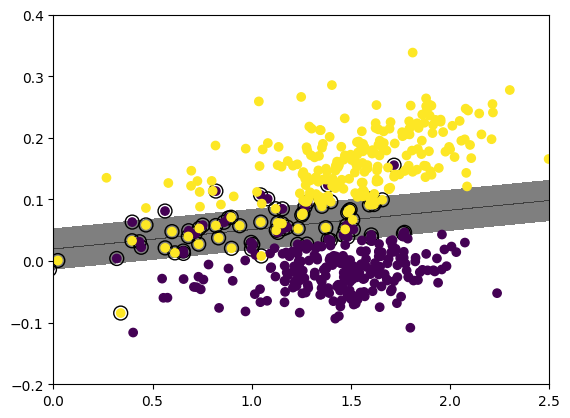

In [140]:
from sklearn.inspection import DecisionBoundaryDisplay
DecisionBoundaryDisplay.from_estimator(
    svm2,
    all_embeddings,
    plot_method="contourf",
    colors='k',
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
    alpha=0.5
)

# plot support vectors
plt.scatter(
    svm2.support_vectors_[:, 0],
    svm2.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.scatter(all_embeddings[:,0], all_embeddings[:,1], c=labels)
plt.xlim([0, 2.5])
plt.ylim([-0.2, 0.4])

In [154]:
svm.coef_

array([[-0.21752893, 11.88835401]])

In [145]:
svm2.coef_

array([[-0.96410674, 30.61620863]])

In [136]:
(svm.predict(all_embeddings) != labels.numpy()).sum()

np.int64(34)

In [146]:
(svm2.predict(all_embeddings) != labels.numpy()).sum()

np.int64(29)

#### d prime calculations

In [156]:
import numpy as np

def mad_sigma(z):
    med = np.median(z)
    mad = np.median(np.abs(z - med))
    return 1.4826 * mad

def dprime_projected_robust(X0, X1, direction=None, pooled=True, use_mad=True):
    # X0, X1: arrays (n0,d), (n1,d)
    mu0 = X0.mean(axis=0); mu1 = X1.mean(axis=0)
    delta = mu1 - mu0


    
    if direction is None:
        norm = np.linalg.norm(delta)
        if norm == 0:
            return 0.0
        u = delta / norm
    else:
        u = direction / (np.linalg.norm(direction) + 1e-12)


    z0 = X0.dot(u); z1 = X1.dot(u)
    m0, m1 = z0.mean(), z1.mean()


    
    if use_mad:
        s0 = mad_sigma(z0); s1 = mad_sigma(z1)
    else:
        s0 = z0.std(ddof=1); s1 = z1.std(ddof=1)

        
    if pooled:
        denom = np.sqrt(0.5 * (s0**2 + s1**2) + 1e-12)
    else:
        denom = np.sqrt(s0**2 + s1**2 + 1e-12)


    return (m1 - m0) / denom

In [157]:
dprime_projected_robust(embeddings_1, embeddings_2)

RuntimeError: 1D tensors expected, but got 2D and 1D tensors

In [161]:
embeddings_1 @ embeddings_1.mean(0)

tensor([ 2.4647,  2.2827,  0.9859,  0.6108,  1.7326,  2.0814,  2.3578,  1.6082,
         2.0460,  2.4702,  1.6825,  2.7017,  2.0864,  2.3697,  2.0896,  2.2631,
         2.2063,  2.1039,  2.4572,  2.0004,  1.7143,  1.6667,  2.2129,  2.0553,
         1.8359,  2.3240,  2.1627,  2.0342,  2.0202,  1.9412,  1.6905,  1.7734,
         2.0768,  2.2631,  2.3807,  1.4061,  1.7758,  2.3448,  2.4426,  1.9701,
         0.9052,  2.5173,  2.2049,  1.6747,  2.7199,  2.2209,  2.0470,  1.9192,
         0.5984,  2.4693,  1.9262,  1.0389,  0.9412,  2.6763,  1.8636,  1.7219,
         2.4313,  2.5490,  1.6089,  1.4379,  0.9038,  1.9260,  2.2128,  2.0637,
         1.4017,  1.9817,  0.9969,  1.4872,  1.8959,  1.4902,  2.4496,  2.5197,
         2.0395,  1.5923,  1.9209,  2.0793,  2.2654,  2.2641,  2.0342,  2.0051,
         2.3931,  2.4348,  2.6032,  1.6123,  2.7348,  1.6422,  2.4376,  2.3048,
         1.3781,  0.9782,  1.8601,  2.0500,  0.7942,  1.7350,  1.5608,  2.0196,
         1.7557,  1.9971,  2.8623,  1.70

In [118]:
activity = None

def record_activity(module, input, output):
    activity = output

In [4]:
model.decoder[0].register_forward_hook(record_activity)

In [ ]:
import numpy as np

def mad_sigma(z):
    med = np.median(z)
    mad = np.median(np.abs(z - med))
    return 1.4826 * mad

def dprime_projected_robust(X0, X1, direction=None, pooled=True, use_mad=True):
    # X0, X1: arrays (n0,d), (n1,d)
    mu0 = X0.mean(axis=0); mu1 = X1.mean(axis=0)
    delta = mu1 - mu0
    if direction is None:
        norm = np.linalg.norm(delta)
        if norm == 0:
            return 0.0
        u = delta / norm
    else:
        u = direction / (np.linalg.norm(direction) + 1e-12)
    z0 = X0.dot(u); z1 = X1.dot(u)
    m0, m1 = z0.mean(), z1.mean()
    if use_mad:
        s0 = mad_sigma(z0); s1 = mad_sigma(z1)
    else:
        s0 = z0.std(ddof=1); s1 = z1.std(ddof=1)
    if pooled:
        denom = np.sqrt(0.5 * (s0**2 + s1**2) + 1e-12)
    else:
        denom = np.sqrt(s0**2 + s1**2 + 1e-12)
    return (m1 - m0) / denom